In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

方法定义

In [2]:
# 生成符合度分布的节点度序列
def generate_degree_sequence(min_degree, max_degree, n):
    # 生成节点度序列
    degrees = [d**-2.5 for d in range(min_degree, max_degree + 1)]
    # 归一化
    norm_factor = sum(degrees)
    degrees = [d / norm_factor for d in degrees]
    # 生成节点度序列
    degree_sequence = [0] * n
    for i in range(n):
        rand_val = random.random()
        cumulative_prob = 0
        for j, prob in enumerate(degrees):
            cumulative_prob += prob
            if rand_val <= cumulative_prob:
                degree_sequence[i] = j + min_degree
                break

    # 防止度为偶数
    if sum(degree_sequence) % 2 != 0:
        degree_sequence[random.randint(0, n-1)] += 1
    return degree_sequence

# 生成有向图
def generate_directed_graph(min_degree, max_degree, n):
    # 生成无向图
    G = nx.configuration_model(generate_degree_sequence(min_degree, max_degree, n))
    # 转换为有向图
    DG = nx.DiGraph()
    for edge in G.edges():
        if random.random() < 0.5:
            DG.add_edge(*edge)
        else:
            DG.add_edge(edge[1], edge[0])
    return DG

# 计算PageRank
def calculate_pagerank(graph, beta=0.85, max_iterations=100, tolerance=1e-6):
    # 获取节点总数
    N = len(graph.nodes())

    # 初始化Pagerank值
    pagerank = {node: 1/N for node in graph.nodes()}

    # 迭代计算Pagerank值
    for _ in range(max_iterations):
        new_pagerank = {}
        # 计算每个节点的新Pagerank值
        for node in graph.nodes():
            sum_pr = 0
            if graph.neighbors(node):
                for neighbor in graph.neighbors(node):
                    if (len(list(graph.neighbors(neighbor))) == 0):
                           continue
                    sum_pr += pagerank[neighbor] / len(list(graph.neighbors(neighbor)))
            else:
                sum_pr = 0
            new_pagerank[node] = (1 - beta) / N + beta * sum_pr

        # 检查收敛条件
        diff = max(abs(new_pagerank[node] - pagerank[node]) for node in graph.nodes())
        if diff < tolerance:
            break

        # 更新Pagerank值
        pagerank = new_pagerank

    return pagerank

def calculate_trustrank(graph, accessible_list, beta=0.85, max_iterations=100, tolerance=1e-6):
    seedsize = math.ceil(len(accessible_list) * 0.05)
    trust_value = 1/seedsize
    trust_list = random.sample(accessible_list, seedsize)
    print(trust_list)
    trustrank = {node : trust_value if node in trust_list else 0 for node in graph.nodes()}
    # 迭代计算Pagerank值
    for _ in range(max_iterations):
        new_trustrank = {}
        # 计算每个节点的新Pagerank值
        for node in graph.nodes():
            sum_pr = 0
            if graph.neighbors(node):
                for neighbor in graph.neighbors(node):
                    if (len(list(graph.neighbors(neighbor))) == 0):
                           continue
                    sum_pr += trustrank[neighbor] / len(list(graph.neighbors(neighbor)))
            else:
                sum_pr = 0
            new_trustrank[node] = (1 - beta) * trust_value + beta * sum_pr if node in trust_list else beta * sum_pr

        # 检查收敛条件
        diff = max(abs(new_trustrank[node] - trustrank[node]) for node in graph.nodes())
        if diff < tolerance:
            break

        # 更新Pagerank值
        trustrank = new_trustrank
    return trustrank

# 绘制有向图
def draw_directed_graph(graph, figsize=(14, 14)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, arrowsize=10)
    plt.title("Directed Graph")
    plt.show()


def spamming_graph(graph, Target_page, num_spam=30, link_probability=0.001):
    spam_pages = ['Spam_Page_{}'.format(i) for i in range(1, num_spam + 1)]

    for spam in spam_pages:
        graph.add_node(spam)
        graph.add_edge(spam, Target_page)
        
    for i in range(len(spam_pages) - 1):
        for j in range(i + 1, len(spam_pages)):
            if (random.random() < link_probability):
                graph.add_edge(spam_pages[i], spam_pages[j])

    for spam_page in spam_pages:
        for node in graph.nodes():
            if (node not in spam_pages) and (random.random() < link_probability * 0.1):
                graph.add_edge(node, spam_page)

    return graph

# 计算Target_page的rank（spam情况下）
def get_target_rank(graph_with_spam):
    pagerank_values = calculate_pagerank(graph_with_spam)
    Node_rank = []
    pro_rank = []
    for node, pr in sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True):
        Node_rank.append(node)
        pro_rank.append(pr)

    df = pd.DataFrame({'Node Rank':Node_rank, 'Pro Rank':pro_rank})

    Target_rank = df[df['Node Rank'] == 'Target_page'].index
    return Target_rank

# 计算spam和Target_page rank的关系
def plot_relationship(accessible_graph, min_num, max_num, Target_page, link_probability=0.01):
    assert max_num > min_num, "max is less than min!"
    num_spam_list = []
    target_rank_list = []
    for num_spam in range(max_num - min_num):
        graph_with_spam = spamming_graph(graph=accessible_graph, Target_page=Target_page, link_probability=link_probability, num_spam=num_spam)
        num_spam_list.append(num_spam)
        target_rank_list.append(get_target_rank(graph_with_spam=graph_with_spam))
    
    plt.scatter(num_spam_list, target_rank_list)
    plt.title("Relationship of Spam number and Rank of Target Page")
    plt.xlabel("Number of Spam")
    plt.ylabel("Rank of Target Page")
    plt.show()

应用PageRank

PageRank值:
Node 98: 0.017881698869652806
Node 37: 0.013034393767039113
Node 4: 0.010737279769108187
Node 25: 0.00987443030784957
Node 12: 0.009797521057360066
Node 24: 0.009284531075976953
Node 36: 0.009204241803318676
Node 81: 0.008986884205173972
Node 45: 0.008481232379349694
Node 27: 0.008108241398889618
Node 21: 0.0080900129426617
Node 48: 0.007911951467909076
Node 40: 0.00786122815397459
Node 56: 0.007324808676697542
Node 22: 0.007166737619204006
Node 70: 0.00689488783902578
Node 53: 0.006641262542609772
Node 14: 0.006421141968996744
Node 47: 0.0062867128706821625
Node 19: 0.0062234850861889734
Node 8: 0.006148460156291522
Node 64: 0.006144210280331973
Node 26: 0.006095661594155369
Node 1: 0.00605927234268001
Node 65: 0.005810345018587993
Node 62: 0.005748539156689502
Node 80: 0.0056938139303525466
Node 16: 0.005646705335701041
Node 11: 0.005630990385517408
Node 99: 0.005358581542308656
Node 76: 0.005357289386312327
Node 86: 0.005161996322311919
Node 7: 0.0051404158447447956
Node 

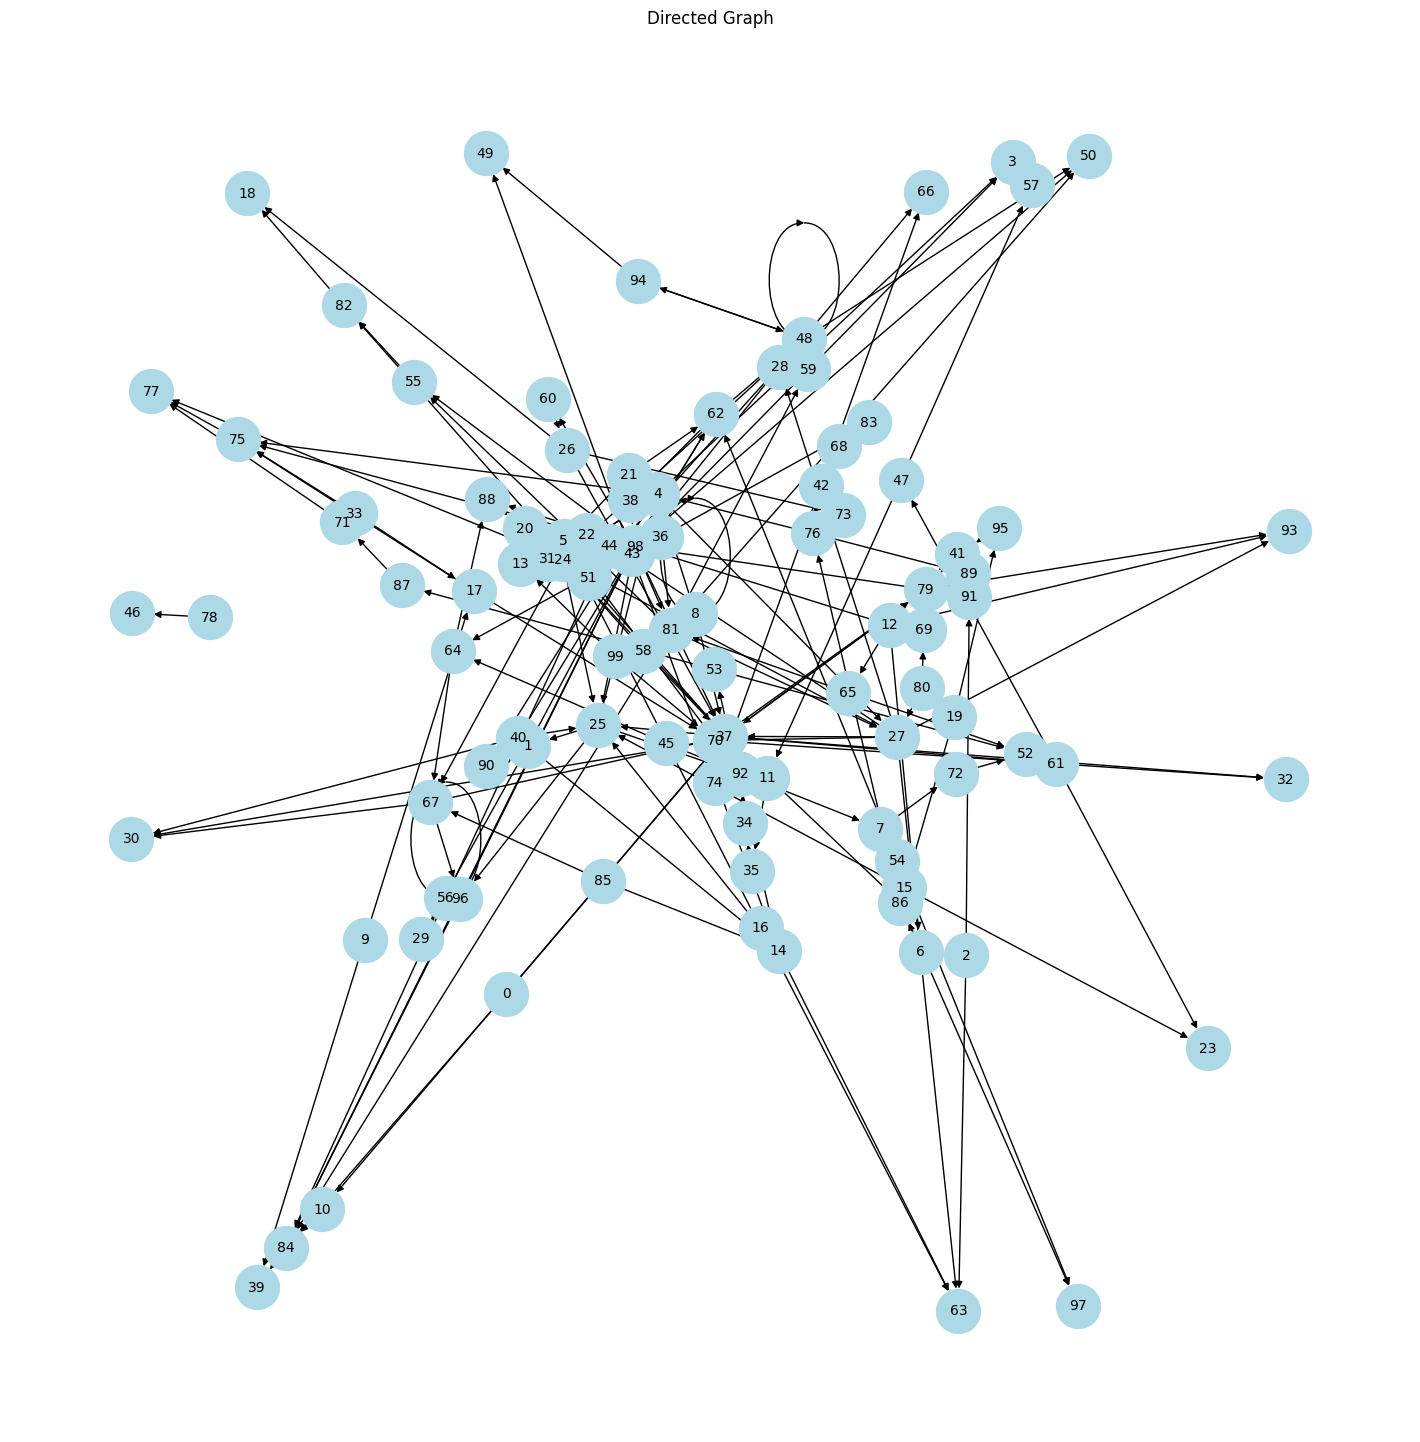

Correlation_coefficient: 0.7219161740708353


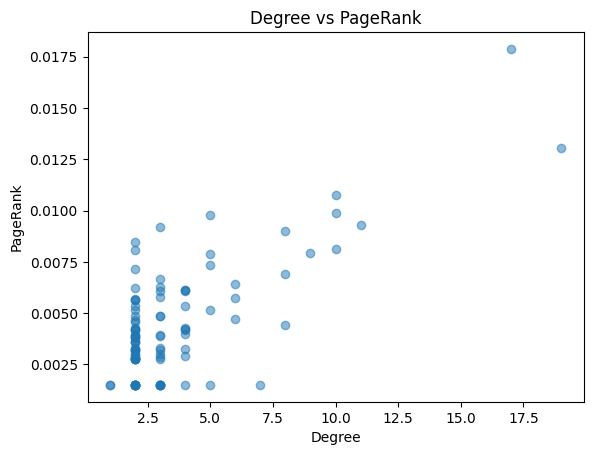

In [3]:
# 生成有向图
accessible_graph = generate_directed_graph(2, 20, 100)

# 计算PageRank
pagerank_values = calculate_pagerank(accessible_graph)

print("PageRank值:")
for node, pr in sorted(pagerank_values.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

# 绘制有向图
draw_directed_graph(accessible_graph)

degrees =dict(accessible_graph.degree())
degree_values_list = np.array(list(degrees.values()))
pagerank_values_list = np.array(list(pagerank_values.values()))
correlation_coefficient = np.corrcoef(degree_values_list, pagerank_values_list)[0][1]

plt.scatter(degree_values_list, pagerank_values_list, alpha=0.5)
plt.title("Degree vs PageRank")
plt.xlabel("Degree")
plt.ylabel("PageRank")
print(f"Correlation_coefficient: {correlation_coefficient}")
plt.show()

设计Spam Farm

In [4]:
# 获取旧节点的所有邻接点（入边和出边）
in_edges = list(accessible_graph.in_edges(0))
out_edges = list(accessible_graph.out_edges(0))

# 保存旧节点的属性（如果有）
old_node_attributes = accessible_graph.nodes[0]

# 删除旧节点
accessible_graph.remove_node(0)

# 添加新节点，并将旧节点的属性复制到新节点上
accessible_graph.add_node('Target_page', **old_node_attributes)

# 将原有关联边重新指向新节点
for source, target in in_edges + out_edges:
    if source == 0:
        # 出边的情况，源节点是旧节点
        accessible_graph.add_edge('Target_page', target)
    elif target == 0:
        # 入边的情况，目标节点是旧节点
        accessible_graph.add_edge(source, 'Target_page')

graph_with_spam = spamming_graph(accessible_graph, Target_page='Target_page')

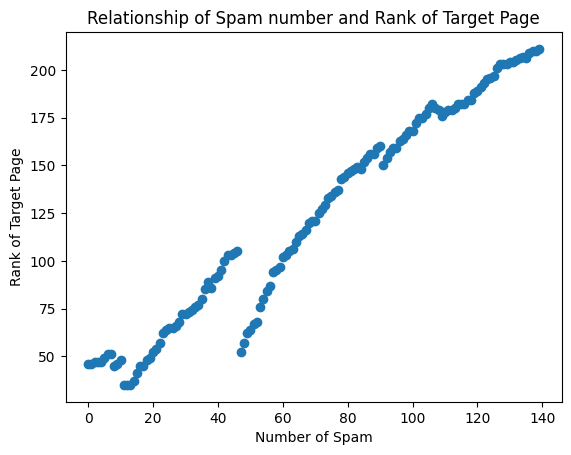

In [5]:
plot_relationship(accessible_graph, 10, 150, Target_page='Target_page')

In [6]:
accessible_list = []
spam_list = []
for node in list(graph_with_spam.nodes):
    if isinstance(node, int):
        accessible_list.append(node)
    elif node.startswith('Spam'):
        spam_list.append(node)

In [7]:
# 计算并打印TrustRank
Trustrank_values = calculate_trustrank(graph_with_spam, accessible_list)
print("TrustRank值:")
for node, pr in sorted(Trustrank_values.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

[98, 14, 60, 68, 91]
TrustRank值:
Node 98: 0.03259197267718023
Node 91: 0.03010340135293561
Node 14: 0.030024626496890052
Node 68: 0.03000662278316681
Node 60: 0.030006538464490005
Node 83: 0.0025578243991313883
Node 2: 0.0018373419754069739
Node 40: 0.0016277418559009305
Node 85: 0.0016086740162108866
Node 43: 0.001600383185137184
Node 36: 0.0013927752270376558
Node 79: 0.0012171450229290376
Node 22: 0.001212437179582525
Node 38: 0.001211863324201338
Node 28: 0.001211689034928378
Node 96: 0.0012105434574713498
Node 1: 0.0012098746144453847
Node 25: 0.00022581003529035398
Node 44: 0.0001564433001181868
Node 37: 0.0001246343176821814
Node 27: 0.00011979720697791475
Node 67: 0.00011586261296017179
Node 70: 0.00010609942460235267
Node 89: 9.902754889412716e-05
Node 41: 9.741037405115696e-05
Node 62: 9.253336172461562e-05
Node 90: 8.367921412790559e-05
Node Spam_Page_5: 4.892487837549822e-05
Node Spam_Page_6: 4.712086083781397e-05
Node Spam_Page_4: 4.5834989138422044e-05
Node Spam_Page_7: 4

In [8]:
spam_pagerank = calculate_pagerank(graph_with_spam)

In [9]:
spam_mass = {}
for node, pr in spam_pagerank.items():
    if spam_pagerank[node] == 0:
        spam_mass[node] = 0
        continue
    spam_mass[node] = spam_pagerank[node] - Trustrank_values[node] / spam_pagerank[node]

In [10]:
print("Spam Mass值:")
for node, pr in sorted(spam_mass.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

Spam Mass值:
Node Spam_Page_5: 0.047554838708910335
Node Spam_Page_6: 0.045583638571222995
Node Spam_Page_4: 0.044168859829391505
Node Spam_Page_7: 0.04396673551248984
Node Spam_Page_1: 0.043554211178713435
Node Spam_Page_18: 0.04223304707408697
Node Spam_Page_11: 0.04202798279378956
Node Spam_Page_13: 0.04181048072986983
Node Spam_Page_3: 0.04166220803357362
Node Spam_Page_14: 0.041451712039629905
Node Spam_Page_8: 0.04134246110881004
Node Spam_Page_2: 0.04128731841465262
Node Spam_Page_15: 0.039484912051230274
Node Spam_Page_12: 0.03837169365990947
Node Spam_Page_16: 0.038342321048518056
Node Spam_Page_27: 0.03820296723302008
Node Spam_Page_23: 0.03781803209612466
Node Spam_Page_17: 0.0375804600406013
Node Spam_Page_19: 0.037388538421331684
Node Spam_Page_21: 0.03681834788937255
Node Spam_Page_29: 0.0362236827464327
Node Spam_Page_20: 0.03563696354767563
Node Spam_Page_34: 0.03428038998825
Node Spam_Page_9: 0.034220360054768716
Node Spam_Page_24: 0.03303023400256172
Node Spam_Page_30:

In [11]:
print("Spam PageRank值:")
for node, pr in sorted(spam_pagerank.items(), key=lambda x: x[1], reverse=True):
    print(f"Node {node}: {pr}")

Spam PageRank值:
Node Spam_Page_5: 0.04856230486020478
Node Spam_Page_6: 0.04659492595650188
Node Spam_Page_4: 0.045183283431602835
Node Spam_Page_7: 0.04497497779200927
Node Spam_Page_1: 0.04456396127194818
Node Spam_Page_18: 0.043240553684087024
Node Spam_Page_11: 0.04302937085127903
Node Spam_Page_13: 0.04281821411017167
Node Spam_Page_3: 0.04266846155802814
Node Spam_Page_14: 0.04245307511001831
Node Spam_Page_8: 0.042344949009641995
Node Spam_Page_2: 0.04229084356079512
Node Spam_Page_15: 0.04048913604194822
Node Spam_Page_12: 0.039373912366366066
Node Spam_Page_16: 0.03934922637707352
Node Spam_Page_27: 0.039204816759192955
Node Spam_Page_23: 0.038816461965617235
Node Spam_Page_17: 0.03858932481407207
Node Spam_Page_19: 0.03839042462858985
Node Spam_Page_21: 0.03782088389310395
Node Spam_Page_29: 0.0372186632031182
Node Spam_Page_20: 0.036645217403865366
Node Spam_Page_34: 0.03527858089436419
Node Spam_Page_9: 0.03522745970641735
Node Spam_Page_24: 0.03403554304393803
Node Spam_Pa